<a href="https://colab.research.google.com/github/duonghung86/Vehicle-trajectory-tracking/blob/master/Codes/VTP_1_10_Models_for_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing models for full dataset
---

## Import packages

In [65]:
# General
import numpy as np
import time
import os

# Loading datasets
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request

# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# For prediction model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

## Load dataset

In [66]:
def url2pd(link):
    with ZipFile(link) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading a dataset!')
    return pd.read_csv(data)

In [69]:
filenames = os.listdir('./Data')
url_1 = './Data/' + filenames[3]
df = url2pd(url_1)
df.info()
df.head(3)

Done loading a dataset!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Vehicle_ID     1048575 non-null  int64  
 1   Frame_ID       1048575 non-null  int64  
 2   Total_Frames   1048575 non-null  int64  
 3   Global_Time    1048575 non-null  int64  
 4   Local_X        1048575 non-null  float64
 5   Local_Y        1048575 non-null  float64
 6   Global_X       1048575 non-null  float64
 7   Global_Y       1048575 non-null  float64
 8   v_Length       1048575 non-null  float64
 9   v_Width        1048575 non-null  float64
 10  v_Class        1048575 non-null  int64  
 11  v_Vel          1048575 non-null  float64
 12  v_Acc          1048575 non-null  float64
 13  Lane_ID        1048575 non-null  int64  
 14  Preceding      1048575 non-null  int64  
 15  Following      1048575 non-null  int64  
 16  Space_Headway  1048575 non-nul

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway
0,1,12,884,1113433136100,16.884,48.213,6042842.116,2133117.662,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0
1,1,13,884,1113433136200,16.938,49.463,6042842.012,2133118.909,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0
2,1,14,884,1113433136300,16.991,50.712,6042841.908,2133120.155,14.3,6.4,2,12.5,0.0,2,0,0,0.0,0.0


Let's take a glance at the data. Here are the first few rows:

In [4]:
# Filter time step
print(df.shape)
df = df.iloc[::2,:].copy()
df.reset_index(drop=True, inplace=True)
print('After filtering:', df.shape)
#  keep only columns that are useful for now
kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID']
df = df[kept_cols]
df.head()

(1048575, 18)
After filtering: (524288, 18)


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [5]:
'the number of vehicles is {}'.format(len(df.Vehicle_ID.unique()))

'the number of vehicles is 1993'

# Model 1

### Constant values

In [54]:
# Set constant values
HISTORY_LENGTH = 3
FUTURE_LENGTH = 5
TIME_STEP = 0.2
n_steps = int(HISTORY_LENGTH/0.2)
n_future = int(FUTURE_LENGTH/0.2)
n_features = len(df)
series_feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
vehicle_ids = df.Vehicle_ID.unique()

## Data preparation

### `series2seq`: Function that return sequence input and output for one object

**Arguments**:

- data: Sequence of observations as a Pandas dataframe.
- n_in: Number of lag observations as input (X).
- n_out: Number of observations as output (y).
- **series_features**: names of series features
- labels: name of target variables
- dropnan: Boolean whether or not to drop rows with NaN values.
    
**Returns**:
- X: Feature Pandas DataFrame
- y: Label Pandas dataframe

  

In [7]:
# Test data frame
# data set of the vehicle #2
df_test = df[df.Vehicle_ID==vehicle_ids[0]].copy()
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 218
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    219 non-null    int64  
 1   Frame_ID      219 non-null    int64  
 2   Total_Frames  219 non-null    int64  
 3   Local_X       219 non-null    float64
 4   Local_Y       219 non-null    float64
 5   v_Length      219 non-null    float64
 6   v_Width       219 non-null    float64
 7   v_Class       219 non-null    int64  
 8   v_Vel         219 non-null    float64
 9   v_Acc         219 non-null    float64
 10  Lane_ID       219 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 20.5 KB


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [55]:
def single_series2seq(pdseries,n_in=3, n_out=10,step_in=1, step_out=5):
    seq = pdseries.copy()
    agg = pd.DataFrame()
    for i in range(n_in, 0, -step_in):
        name = '{}(-{:.1f}s)'.format(seq.name, (i-1)*TIME_STEP)
        agg[name] = seq.shift(i)
    input_len = agg.shape[1]
    for i in range(0, n_out,1):
        name = '{0}({1:.2f}s)'.format(seq.name, (i+1)*TIME_STEP)
        agg[name] = seq.shift(-i)
    # put it all together
    agg.dropna(inplace=True)
    agg.reset_index(drop=True,inplace=True)
    
    X = agg.iloc[:,:input_len].copy()
    Y = agg.iloc[:,input_len:].copy()
    Y = Y.iloc[:,step_out-1::step_out]
    return X,Y
test_series = pd.Series(np.arange(20),name='test')
single_series2seq(test_series)

(   test(-0.4s)  test(-0.2s)  test(-0.0s)
 0          0.0          1.0          2.0
 1          1.0          2.0          3.0
 2          2.0          3.0          4.0
 3          3.0          4.0          5.0
 4          4.0          5.0          6.0
 5          5.0          6.0          7.0
 6          6.0          7.0          8.0
 7          7.0          8.0          9.0,
    test(1.00s)  test(2.00s)
 0          7.0         12.0
 1          8.0         13.0
 2          9.0         14.0
 3         10.0         15.0
 4         11.0         16.0
 5         12.0         17.0
 6         13.0         18.0
 7         14.0         19.0)

In [56]:
def multiseries2seq(data, **kwarg):
    dat = data.copy()
    n_series = dat.shape[1]
    X, Y = pd.DataFrame(), pd.DataFrame()
    for feat in dat.columns:
        newX, newY = single_series2seq(dat[feat],
                                       n_in = kwarg['n_in'],
                                       step_in = kwarg['step_in'],
                                       n_out = kwarg['n_out'],
                                       step_out = kwarg['step_out'])
        X = pd.concat((X,newX),axis = 1)
        Y = pd.concat((Y,newY),axis = 1)
    return X,Y

test_df = pd.DataFrame(np.arange(90).reshape(-1,2),columns=['a','b'])
multiseries2seq(test_df,n_in=n_steps, n_out=n_future,step_in=1, step_out=5)

(   a(-2.8s)  a(-2.6s)  a(-2.4s)  a(-2.2s)  a(-2.0s)  a(-1.8s)  a(-1.6s)  \
 0       0.0       2.0       4.0       6.0       8.0      10.0      12.0   
 1       2.0       4.0       6.0       8.0      10.0      12.0      14.0   
 2       4.0       6.0       8.0      10.0      12.0      14.0      16.0   
 3       6.0       8.0      10.0      12.0      14.0      16.0      18.0   
 4       8.0      10.0      12.0      14.0      16.0      18.0      20.0   
 5      10.0      12.0      14.0      16.0      18.0      20.0      22.0   
 
    a(-1.4s)  a(-1.2s)  a(-1.0s)  ...  b(-1.8s)  b(-1.6s)  b(-1.4s)  b(-1.2s)  \
 0      14.0      16.0      18.0  ...      11.0      13.0      15.0      17.0   
 1      16.0      18.0      20.0  ...      13.0      15.0      17.0      19.0   
 2      18.0      20.0      22.0  ...      15.0      17.0      19.0      21.0   
 3      20.0      22.0      24.0  ...      17.0      19.0      21.0      23.0   
 4      22.0      24.0      26.0  ...      19.0      21.0    

### `treatment_cars` Function to prepare the data set for each car

In [32]:
# Test data frame
# data set of the first 5 vehicles
df_test = df[df.Vehicle_ID.isin(vehicle_ids[:5])].copy()
df_test.info()
print(df_test.Vehicle_ID.unique())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    1023 non-null   int64  
 1   Frame_ID      1023 non-null   int64  
 2   Total_Frames  1023 non-null   int64  
 3   Local_X       1023 non-null   float64
 4   Local_Y       1023 non-null   float64
 5   v_Length      1023 non-null   float64
 6   v_Width       1023 non-null   float64
 7   v_Class       1023 non-null   int64  
 8   v_Vel         1023 non-null   float64
 9   v_Acc         1023 non-null   float64
 10  Lane_ID       1023 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 95.9 KB
[2 4 5 6 8]


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [57]:
%%time
def treatment_cars(data,labels=None,**kwarg):
    veh_ids = data.Vehicle_ID.unique()
    dat_X, dat_y = pd.DataFrame(),pd.DataFrame()

    for id in veh_ids:
        dat = data[data.Vehicle_ID==id].copy()
        X, Y = multiseries2seq(dat[labels],
                               n_in = kwarg['n_in'],
                               step_in = kwarg['step_in'],
                               n_out = kwarg['n_out'],
                               step_out = kwarg['step_out']) 
        dat_X = pd.concat([dat_X,X],ignore_index=True)
        dat_y = pd.concat([dat_y,Y],ignore_index=True)
    print(dat_X.shape, dat_y.shape)
    return dat_X ,dat_y
treatment_cars(df_test,n_in=n_steps, n_out=n_future,step_in=1, step_out=5, labels = target_names);

(180, 30) (180, 10)
Wall time: 38.9 ms


(     Local_X(-2.8s)  Local_X(-2.6s)  Local_X(-2.4s)  Local_X(-2.2s)  \
 0         16.467196       16.425991       16.384804       16.342611   
 1         16.425991       16.384804       16.342611       16.304035   
 2         16.384804       16.342611       16.304035       16.260427   
 3         16.342611       16.304035       16.260427       16.210198   
 4         16.304035       16.260427       16.210198       16.205399   
 ..              ...             ...             ...             ...   
 175        8.124364        8.106310        8.089186        8.103336   
 176        8.106310        8.089186        8.103336        8.142688   
 177        8.089186        8.103336        8.142688        8.136984   
 178        8.103336        8.142688        8.136984        8.057219   
 179        8.142688        8.136984        8.057219        7.913133   
 
      Local_X(-2.0s)  Local_X(-1.8s)  Local_X(-1.6s)  Local_X(-1.4s)  \
 0         16.304035       16.260427       16.210198       16.

### Choose the size of the raw data set

In [58]:
%%time
X, y = treatment_cars(df, 
                   n_in=n_steps, n_out=n_future,step_in=1, step_out=5, labels = target_names)

(446561, 30) (446561, 10)
Wall time: 1min 43s


### Split the data set


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(312592, 30) (133969, 30) (312592, 10) (133969, 10)


In [36]:
X_train.describe()

,Local_X(t-14),Local_X(t-13),Local_X(t-12),Local_X(t-11),Local_X(t-10),Local_X(t-9),Local_X(t-8),Local_X(t-7),Local_X(t-6),Local_X(t-5),...,v_Vel(t-9),v_Vel(t-8),v_Vel(t-7),v_Vel(t-6),v_Vel(t-5),v_Vel(t-4),v_Vel(t-3),v_Vel(t-2),v_Vel(t-1),v_Vel(t-0)
count,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,...,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000,311197.000000
mean,28.949394,28.950635,28.951963,28.953384,28.954937,28.956629,28.958471,28.960448,28.962531,28.964720,...,36.644794,36.714316,36.785323,36.858862,36.935355,37.014264,37.094058,37.174057,37.253491,37.332458
std,16.599254,16.588448,16.578098,16.568184,16.558737,16.549768,16.541265,16.533157,16.525387,16.517913,...,12.995729,13.041057,13.086673,13.132066,13.178058,13.224797,13.272437,13.320504,13.371120,13.423478
min,0.538832,0.551364,0.637033,0.757823,0.868828,0.969140,1.077501,1.231741,1.442382,1.702937,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.978291,16.996632,17.015014,17.039061,17.057979,17.074904,17.090946,17.109352,17.124874,17.139506,...,29.997057,29.998300,29.998981,29.999330,30.000019,30.000162,30.000589,30.001431,30.002454,30.004397
50%,29.327063,29.335664,29.342809,29.351522,29.358559,29.365816,29.370944,29.377312,29.383175,29.390282,...,38.744593,38.833585,38.930969,39.019813,39.114523,39.202298,39.262013,39.340377,39.402891,39.489300
75%,41.590620,41.594103,41.596480,41.600459,41.604016,41.603769,41.606543,41.609991,41.612464,41.613613,...,45.062879,45.092883,45.122377,45.164743,45.214502,45.277926,45.366331,45.468905,45.595627,45.734737
max,72.718394,72.075172,71.430697,70.899035,70.791932,70.689543,70.500392,70.213807,69.936403,69.863166,...,100.254935,111.429186,111.429186,111.429186,111.429186,100.254935,111.429186,111.429186,111.429186,111.429186


In [60]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(312592, 30)


,Local_X(-2.8s),Local_X(-2.6s),Local_X(-2.4s),Local_X(-2.2s),Local_X(-2.0s),Local_X(-1.8s),Local_X(-1.6s),Local_X(-1.4s),Local_X(-1.2s),Local_X(-1.0s),...,v_Vel(-1.8s),v_Vel(-1.6s),v_Vel(-1.4s),v_Vel(-1.2s),v_Vel(-1.0s),v_Vel(-0.8s),v_Vel(-0.6s),v_Vel(-0.4s),v_Vel(-0.2s),v_Vel(-0.0s)
count,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,...,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05,3.125920e+05
mean,-5.696353e-15,1.511554e-14,9.490375e-15,2.276768e-14,2.066591e-14,-4.833633e-15,-4.000235e-15,2.701209e-14,3.597961e-14,4.055230e-14,...,3.890742e-14,5.454569e-14,1.035330e-13,-1.510072e-14,6.767938e-14,2.201211e-14,-4.903595e-14,6.881007e-14,4.544828e-14,6.158326e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.714827e+00,-1.715222e+00,-1.711156e+00,-1.704923e+00,-1.699243e+00,-1.694185e+00,-1.688609e+00,-1.680216e+00,-1.668360e+00,-1.653438e+00,...,-2.824302e+00,-2.819626e+00,-2.814900e+00,-2.810722e+00,-2.806906e+00,-2.802912e+00,-2.798538e+00,-2.793656e+00,-2.788894e+00,-2.784464e+00
25%,-7.207344e-01,-7.201612e-01,-7.195296e-01,-7.189608e-01,-7.185234e-01,-7.180376e-01,-7.175088e-01,-7.172072e-01,-7.166344e-01,-7.161427e-01,...,-5.161545e-01,-5.196235e-01,-5.232568e-01,-5.271773e-01,-5.312872e-01,-5.352657e-01,-5.390515e-01,-5.426857e-01,-5.463168e-01,-5.499174e-01
50%,2.268454e-02,2.308297e-02,2.346279e-02,2.370978e-02,2.405150e-02,2.427177e-02,2.453360e-02,2.475762e-02,2.504830e-02,2.545972e-02,...,1.608486e-01,1.625012e-01,1.625502e-01,1.625816e-01,1.631251e-01,1.624913e-01,1.618193e-01,1.610892e-01,1.596668e-01,1.583465e-01
75%,7.606606e-01,7.612477e-01,7.617209e-01,7.623717e-01,7.628900e-01,7.633358e-01,7.637926e-01,7.642088e-01,7.647174e-01,7.651634e-01,...,6.437370e-01,6.386654e-01,6.334101e-01,6.289899e-01,6.252756e-01,6.224408e-01,6.209026e-01,6.217764e-01,6.230510e-01,6.254978e-01
max,2.677518e+00,2.640044e+00,2.602741e+00,2.565238e+00,2.527977e+00,2.523019e+00,2.512750e+00,2.496497e+00,2.480711e+00,2.473176e+00,...,4.788673e+00,4.866814e+00,5.697086e+00,5.671052e+00,5.645389e+00,4.675934e+00,4.751791e+00,5.566216e+00,5.539202e+00,5.512924e+00


### Reshape data sets


In [61]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [62]:
%%time
# define model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1],1)))
model.add(Dense(y_test.shape[1]))
model.compile(optimizer='adam', loss='mse')

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=50, batch_size= 1024,
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
306/306 [==============================] - 8s 12ms/step - loss: 1112.6633 - val_loss: 525.6802
Epoch 2/50
306/306 [==============================] - 3s 10ms/step - loss: 444.0546 - val_loss: 293.0713
Epoch 3/50
306/306 [==============================] - 3s 9ms/step - loss: 264.1299 - val_loss: 175.8460
Epoch 4/50
306/306 [==============================] - 3s 9ms/step - loss: 158.7347 - val_loss: 123.4060
Epoch 5/50
306/306 [==============================] - 3s 9ms/step - loss: 113.8494 - val_loss: 92.6719
Epoch 6/50
306/306 [==============================] - 3s 9ms/step - loss: 85.7983 - val_loss: 69.3200
Epoch 7/50
306/306 [==============================] - 3s 9ms/step - loss: 64.3032 - val_loss: 53.0378
Epoch 8/50
306/306 [==============================] - 3s 10ms/step - loss: 49.4618 - val_loss: 41.2110
Epoch 9/50
306/306 [==============================] - 3s 10ms/step - loss: 38.7391 - val_loss: 33.5594
Epoch 10/50
306/306 [==============================] - 3s 10ms/step 

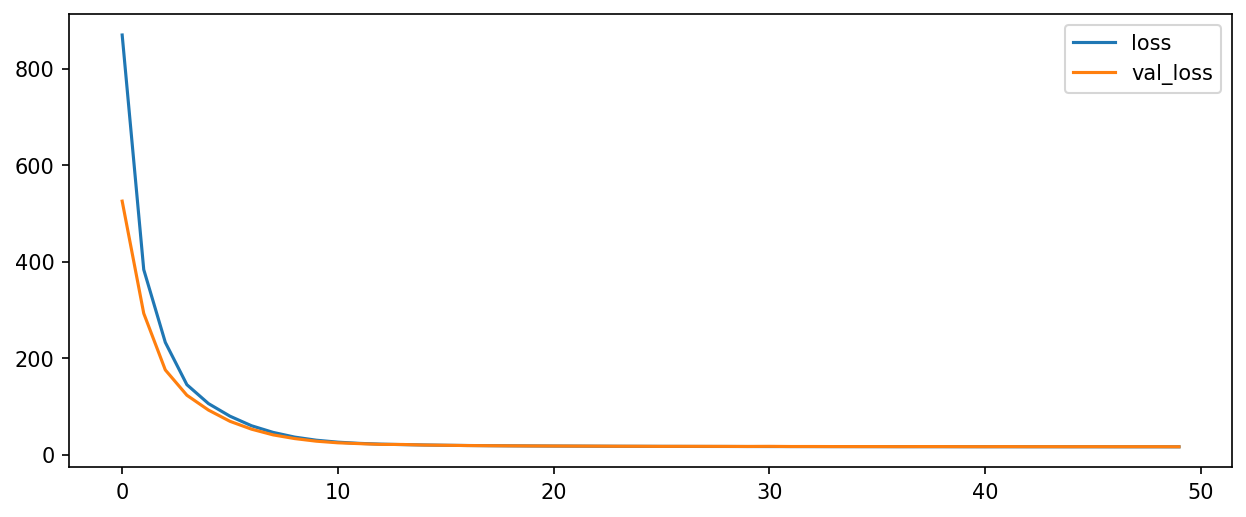

In [63]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes)
#hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()

## Evaluation 


In [64]:
y_hat = model.predict(X_test, verbose=1)
colnames = [str(i)+'s' for i in range(1,6)]
rmse = np.sqrt(np.square(np.subtract(y_test.values,y_hat)).mean(0)).reshape(2,-1)
rmse = pd.DataFrame(rmse,columns = colnames, index = target_names )
rmse.round(3)

4187/4187 [==============================] - 6s 1ms/step


,1s,2s,3s,4s,5s
Local_X,0.958,1.243,1.510,1.762,2.000
v_Vel,3.199,4.252,5.361,6.439,7.443


# END